### **Proyecto Sistema de detección de enlaces spam - Luis Alpizar**
- **Source**: 4Geeks
- **URL**: "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
- **Goal**: Implementar un sistema que sea capaz de detectar automáticamente si una página web contiene spam basándonos en su URL

### Sistema de agrupación de casas

Clasificar casas según su la región en la que se encuentren y del ingreso medio.

### Paso 0: Importar librerias

In [49]:
import pandas as pd
import numpy as np


import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import pickle

from IPython import get_ipython
from IPython.display import display

download("wordnet") # Descarga el recurso "WordNet" para la lematización
download("stopwords") # # Descarga la lista de stopwords (palabras poco relevantes y comunues en el idioma)

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Paso 1: Carga del dataset

In [4]:
url = ('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


### Paso 2: Data preprocessing

In [12]:
df_baking = df_raw.copy()
df_baking["is_spam"] = df_baking["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int) #Cambiar True a 1 y False a 0
df_baking = df_baking.drop_duplicates() #Eliminar filas duplicadas
df_baking = df_baking.reset_index(inplace = False, drop=True) #Reiniciar indices
df_baking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.1+ KB


In [13]:
def preprocesar_url(text):

    text = re.sub(r'[^a-z ]', " ", text) # Reemplaza cualquier carácter por un espacio. Excepto letras minúsculas (a-z) o espacios en blanco.
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)  # Elimina espacios alrededor de caracteres sueltos.
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)  # Filtra ciertos patrones con ^ seguidos de letras y espacios.
    text = re.sub(r'\s+', " ", text.lower())  # Convierte a minúsculas y espacios múltiples a uno solo.
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)  # Elimina tags HTML/XML, reemplazándolas con <>.

    return text.split() # Toma el texto resultante y l devide en un conjunto de palabras


df_baking["url"] = df_baking["url"].apply(preprocesar_url)
df_baking.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


In [15]:
lematizador = WordNetLemmatizer()  # Inicializa el lematizador, que extrae la raiz de las palabras.
stop_words = stopwords.words("english")  # Lista de palabras irrelevantes  en ingles(stopwords).

def lematizar_texto(words, lemmatizer = lematizador):
    tokens = [lemmatizer.lemmatize(word) for word in words]  # Convierte cada palabra en su forma raíz.
    tokens = [word for word in tokens if word not in stop_words]  # Filtrado de stopwords
    tokens = [word for word in tokens if len(word) > 3]  # Filtrado de palabras cortas
    return tokens

df_baking["url"] = df_baking["url"].apply(lematizar_texto)
df_baking.head()

,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


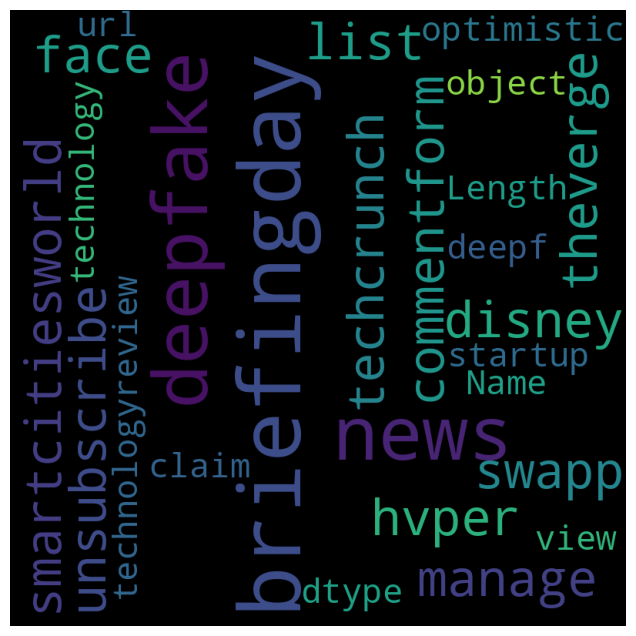

In [27]:
wordcloud = WordCloud(
    width = 800,
    height = 800,
    background_color = "black",
    max_words = 1000,
    min_font_size = 20,
    random_state = 2025)\
    .generate(str(df_baking["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [28]:
df = df_baking.copy()
df.sample(10, random_state=2025)

,url,is_spam
946,"[http, proof, product, proof]",0
1987,"[http, morningbrew, daily, story, lululemon, a...",0
225,"[http, politico, news, takeaway, biden, trump,...",0
1422,"[http, city, journal, plummeting, confidence, ...",0
1293,"[http, nytimes, business, kanye, west, yeezy, ...",0
692,"[http, story, underground, railroad, north, ko...",0
1153,"[http, ownyourcontent, wordpress, paul, jarvis]",0
236,"[http, sakara, page, skimm]",0
930,"[http, austinkleon, learn, alone]",0
135,"[http, realclearpolitics, article, medium, beg...",0


### Paso 3: Machine Learning - Support Vector Machine(SVM)

In [30]:
lista_tokens = df["url"]
lista_tokens = [" ".join(tokens) for tokens in lista_tokens]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5) #Convierte texto en vectores numéricos basados en la importancia de cada palabra.
X = vectorizer.fit_transform(lista_tokens).toarray()
y = df["is_spam"]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2025)

In [34]:
svm_model = SVC(kernel = "linear", random_state = 2025)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=2025)

In [35]:
y_hat = svm_model.predict(X_test)
y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [42]:
print(f"Accuracy: {accuracy_score(y_test, y_hat):.2f}")

Accuracy: 0.94


### Paso 4: Optimizar el modelo anterior

In [39]:
hyperparametros = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}

grid_svm = GridSearchCV(svm_model, hyperparametros, scoring = "accuracy", cv = 5)
grid_svm

GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=2025),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [41]:
grid_svm.fit(X_train, y_train)

print(f"Mejores hyperparametros: {grid_svm.best_params_}")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
350 fits failed out of a total of 1750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

Best hyperparameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


In [45]:
best_svm_model = SVC(C = 1, degree = 2, gamma = "scale", kernel = "poly", random_state = 2025)
best_svm_model.fit(X_train, y_train)
y_hat = best_svm_model.predict(X_test)


In [46]:
print(f"Accuracy: {accuracy_score(y_test, y_hat):.2f}")

Accuracy: 0.94


### Paso 5: Guardar el modelo

In [50]:
with open("best_svm_model.pkl", "wb") as best_svm_model01:
    pickle.dump(best_svm_model, best_svm_model01)